In [1]:
import csv  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
plt.rcParams['figure.figsize'] = [20, 19]

In [2]:
def get_cards(x):
    cards = np.array([
        card for card in range(1,14) # Values
        for suits in range(1,5)      # Suits
        for num_decks in range(x)  # Number of decks
    ])
    rng = default_rng()
    rng.shuffle(cards)
    return cards

In [3]:
def pop(arr):
    select, arr = arr[-1], arr[:-1]
    return 10 if select > 10 else (11 if select == 1 else select), arr, select == 1

In [4]:
# Sim Variables

n = 10000
dealer_threshold = 17
stand_threshold = 17
hit_threshold = 12
data = np.array([])

In [5]:
def play_blackjack(num, n_decks=8):
    rng = default_rng()
    cards = get_cards(n_decks)
    header = ['player_hand', 'player_picked_card', 'dealer_card','dealer_total', 'hit', 'win']

    with open('result.csv', 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        
        # write the header
        writer.writerow(header)
    
        for _ in range(num):
            hit = False
            if len(cards) < (n_decks/2)*52:
                cards = get_cards(n_decks)

            player_card_1, cards, ace_check1 = pop(cards)
            dealer_card_1, cards, _ = pop(cards)
            player_card_2, cards, ace_check2 = pop(cards)
            dealer_hidden, cards, _ = pop(cards)

            ace = ace_check1 or ace_check2

            player_total = player_card_1+player_card_2
            dealer_total = dealer_card_1+dealer_hidden

            # If dealer Blackjack right away, player lose
            if dealer_total == 21:
                writer.writerow([player_total, None, dealer_card_1, dealer_total, 0, 0])
                continue

            picked = None
            while rng.choice([True, False]) and player_total <= 21:
                hit = True
                hand, cards, ace_check3 = pop(cards)
                if player_total+hand > 21 and (ace or ace_check3): #If contains ace and > 21 change ace to 1
                    ace = False
                    picked = 1 if hand == 11 else hand
                    player_total+=(-10 + hand)
                else:
                    picked = hand
                    player_total+=hand

            # If player over 21 lose
            if player_total > 21:
                writer.writerow([player_total-picked if picked else player_total, picked if hit else None, dealer_card_1, dealer_total, 1 if hit else 0, 0])
                continue

            ## Dealer Deals
            while dealer_total < dealer_threshold:
                card, cards, _ = pop(cards)
                dealer_total+=card

            if dealer_total > 21:
                writer.writerow([player_total-picked if picked else player_total, picked if hit else None, dealer_card_1, dealer_total, 1 if hit else 0, 1])
                continue
            elif dealer_total > player_total:
                writer.writerow([player_total-picked if picked else player_total, picked if hit else None, dealer_card_1, dealer_total,1 if hit else 0, 0 ])
                continue
            elif player_total > dealer_total:
                writer.writerow([player_total-picked if picked else player_total, picked if hit else None, dealer_card_1, dealer_total,1 if hit else 0, 1 ])
                continue
            else:
                continue
        print(f'Completed')

In [6]:
play_blackjack(200000, n_decks=8)
df = pd.read_csv("result.csv")

Completed


## P(Win | Stand) Matrix

In [7]:
player_hands = np.arange(3,22)
dealer_hands = np.arange(2,12)

p_win_given_stand = []

for dealer in range(2,12):
    for player in range(3,22):
        display = df[(df['player_hand'] == player) & (df['dealer_card'] == dealer)]
        stand = display[display['hit'] == 0]
        total_stand = 1e-7 if len(stand) == 0 else len(stand)
        p = len(stand[stand['win'] == 1])/total_stand
        p_win_given_stand.append(round(p,3))

p_win_given_stand = np.array(p_win_given_stand, dtype='f').reshape(len(dealer_hands), len(player_hands))

## P(Win | Hit) Matrix

In [8]:
player_hands = np.arange(3,22)
dealer_hands = np.arange(2,12)

p_win_given_hit = []

for dealer in range(2,12):
    for player in range(3,22):
        display = df[(df['player_hand'] == player) & (df['dealer_card'] == dealer)]
        hit = display[display['hit'] == 1]
        total_hit = 1e-7 if len(hit) == 0 else len(hit)
        p = len(hit[hit['win'] == 1])/total_hit
        p_win_given_hit.append(round(p,3))

p_win_given_hit = np.array(p_win_given_hit, dtype='f').reshape(len(dealer_hands), len(player_hands))

## Hit > Stand Matrix

In [9]:
determine = (p_win_given_hit > p_win_given_stand)

# Visualise

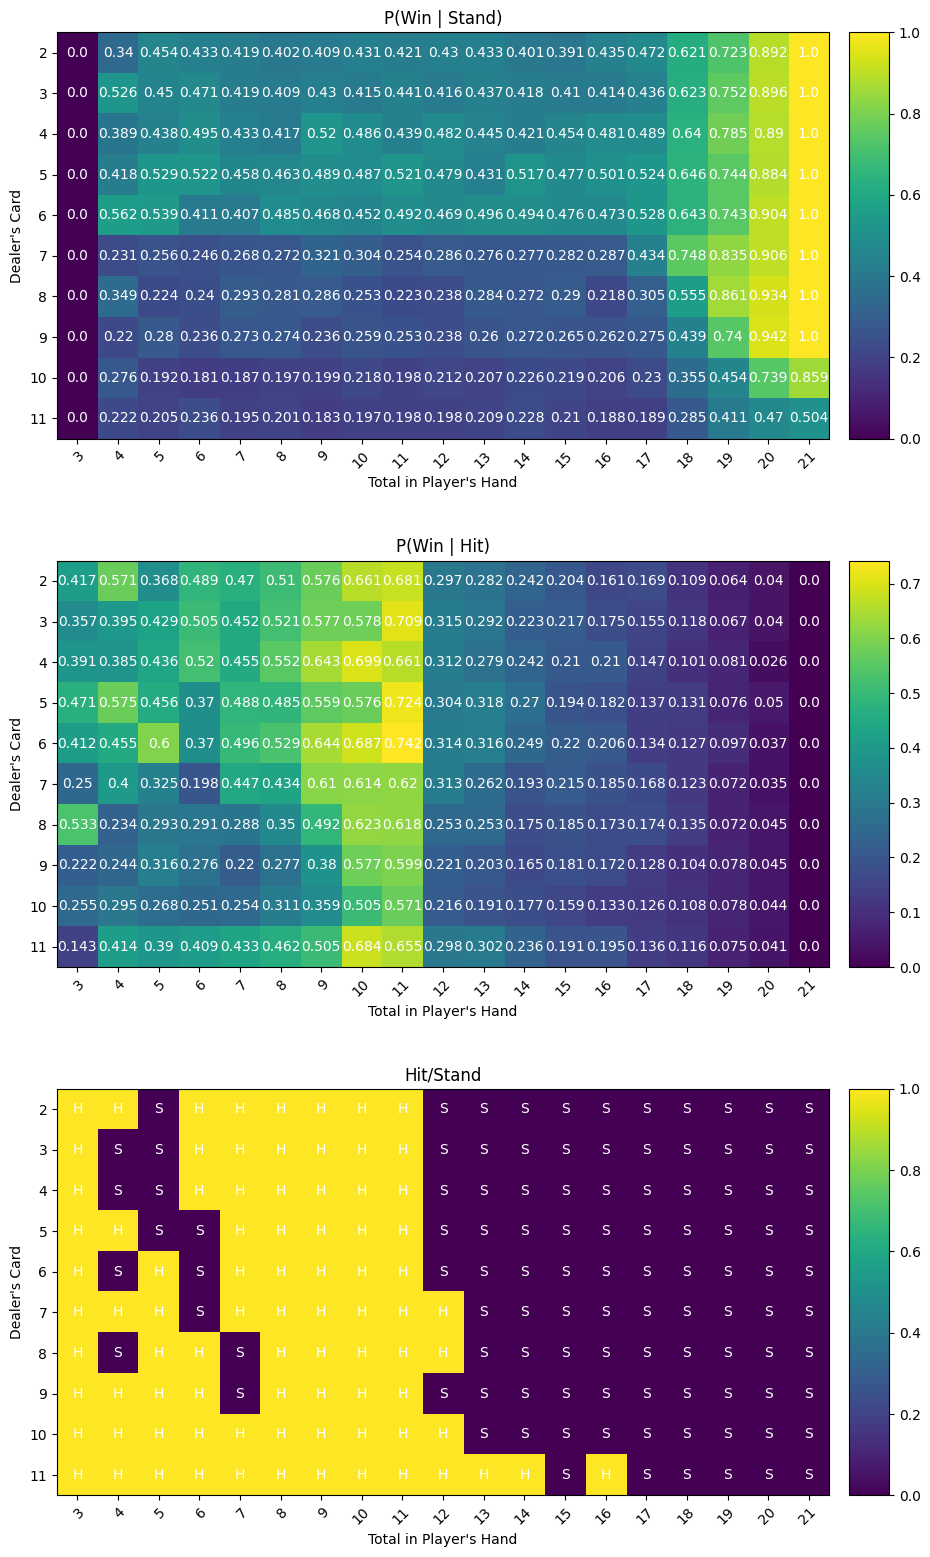

In [10]:
fig, axes = plt.subplots(3,1)
ax, ax2, ax3 = axes
plt.subplots_adjust(hspace=0.3)
im = ax.imshow(p_win_given_stand)
im2 = ax2.imshow(p_win_given_hit)
im3 = ax3.imshow(determine)

### Heat Map 1 Formatting
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(player_hands)), labels=player_hands)
ax.set_yticks(np.arange(len(dealer_hands)), labels=dealer_hands)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_hands)):
    for j in range(len(player_hands)):
        text = ax.text(j, i, p_win_given_stand[i, j],
                       ha="center", va="center", color="w")

ax.set_title("P(Win | Stand)")
ax.set(xlabel="Total in Player's Hand", ylabel="Dealer's Card")
# fig.tight_layout()
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

### Heat Map 2 Formatting
# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(player_hands)), labels=player_hands)
ax2.set_yticks(np.arange(len(dealer_hands)), labels=dealer_hands)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_hands)):
    for j in range(len(player_hands)):
        text = ax2.text(j, i, p_win_given_hit[i, j],
                       ha="center", va="center", color="w")

ax2.set_title("P(Win | Hit)")
ax2.set(xlabel="Total in Player's Hand", ylabel="Dealer's Card")
cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
plt.colorbar(im2, cax=cax)

### Heat Map 3 Formatting
# Show all ticks and label them with the respective list entries
ax3.set_xticks(np.arange(len(player_hands)), labels=player_hands)
ax3.set_yticks(np.arange(len(dealer_hands)), labels=dealer_hands)

# Rotate the tick labels and set their alignment.
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_hands)):
    for j in range(len(player_hands)):
        text = ax3.text(j, i, "H" if determine[i, j] else "S",
                        ha="center", va="center", color="w")

ax3.set_title("Hit/Stand")
ax3.set(xlabel="Total in Player's Hand", ylabel="Dealer's Card")
cax = fig.add_axes([ax3.get_position().x1+0.01,ax3.get_position().y0,0.02,ax3.get_position().height])
plt.colorbar(im3, cax=cax)

plt.savefig('Visual_1.png', transparent=True, bbox_inches='tight')
plt.show()

In [11]:
def play_blackjack_with_p(num, probability, n_decks=8):
    cards=get_cards(n_decks)
    lose = 0
    push = 0
    win = 0

    for _ in range(num):
        # cards = get_cards(1)
        if len(cards) < (n_decks/2)*52:
            cards = get_cards(n_decks)

        player_card_1, cards, _ = pop(cards)
        dealer_card_1, cards, _ = pop(cards)
        player_card_2, cards, _  = pop(cards)
        dealer_hidden, cards, _ = pop(cards)

        player_total = player_card_1+player_card_2
        dealer_total = dealer_card_1+dealer_hidden

        # print(dealer_card_1-1,player_total-2)

        if dealer_card_1 == 1 and dealer_hidden == 10:
            lose+=1
            continue

        # print(dealer_card_1-2,player_total-3)
        while player_total <= 21 and probability[dealer_card_1-3,player_total-4]:
            last_card, cards, _ = pop(cards)
            player_total += last_card

        if player_total > 21:
            lose+=1
            continue

        ## Dealer Deals

        while dealer_total < dealer_threshold:
            card, cards, _ = pop(cards)
            dealer_total+=card

        if dealer_total > 21:
            # write the data
            win+=1
        elif player_total > dealer_total:
            win+=1
        elif dealer_total > player_total:
            lose+=1
        else:
            push+=1
    print(f'Win: {win}, Lost: {lose}, Push: {push}, Winrate: {(win/num) * 100}%')
    return win, lose, push

In [12]:
play_blackjack_with_p(1000000, determine, n_decks=8)

Win: 433294, Lost: 497235, Push: 69471, Winrate: 43.3294%


(433294, 497235, 69471)